## Introduction

In this script we will be looking at implementing an RNN using just numpy. The RNN is used to classify reviews into either positive / negative. This is a single layered RNN with 8 hidden units.


## Resources

The following Github Repository helped me a lot in understanding the inner workings of an RNN -> https://github.com/CaptainE/RNN-LSTM-in-numpy/blob/master/RNN_LSTM_from_scratch.ipynb


## Import Libraries and Data

The below script imports numpy, pandas, and nltk libraries, reads the CSV file containing order reviews data using pandas.

In [1]:
import numpy as np
import pandas as pd


from nltk.corpus import stopwords
review_list = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv')
review_list_subset = review_list[['review_score','review_comment_message']]


## Filter the data and create "sentiment" column

In the following step, we do multiple levels of data processing to clean and preprocess text data contained in the `review_list_subset` dataframe. It includes removing stopwords, converting text to lowercase, replacing punctuation and digits with whitespace, and dropping null values.

It also adds a new column called 'sentiment' to the dataframe, which is based on the `review score` column. Reviews with scores below 4 are labeled as 'NEG', and those with scores 4 and above are labeled as 'POS'.

Finally, the script filters the dataframe to keep only 10,000 positive and 10,000 negative reviews(for a balanced dataset), concatenates them, shuffles the resulting dataframe, and drops any remaining null values. 

In [2]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('portuguese'))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)



review_list_subset = review_list_subset.loc[~review_list_subset['review_comment_message'].isna()]

review_list_subset['sentiment'] = 'POS'

review_list_subset.loc[review_list_subset['review_score']<4,'sentiment']= 'NEG'



review_list_subset['review_comment_message'] = review_list_subset['review_comment_message'].str.lower()


review_list_subset['review_comment_message'] = review_list_subset['review_comment_message'].str.replace('!',' ')

review_list_subset['review_comment_message'] = review_list_subset['review_comment_message'].str.replace('.',' ')

review_list_subset['review_comment_message'] = review_list_subset['review_comment_message'].str.replace(',',' ')

review_list_subset['review_comment_message'] = review_list_subset['review_comment_message'].str.replace('-',' ')

review_list_subset['review_comment_message'] = review_list_subset['review_comment_message'].str.replace('_',' ')

review_list_subset['review_comment_message'] = review_list_subset['review_comment_message'].str.replace('0|1|2|3|4|5|6|7|8|9',' ',regex=True)


review_list_subset['review_comment_message'] = review_list_subset['review_comment_message'].apply(remove_stopwords)

review_list_subset['review_comment_message'] = review_list_subset['review_comment_message'].str.strip()


# review_list_subset['len'] = review_list_subset['review_comment_message'].apply(lambda x: len(x.split()))




review_list_subset.reset_index(inplace = True)

review_list_subset.drop('index',inplace=True,axis=1)

review_list_pos = review_list_subset[review_list_subset['sentiment']=='POS']

review_list_pos = review_list_pos.head(10000)

review_list_neg = review_list_subset[review_list_subset['sentiment']=='NEG']

review_list_neg = review_list_neg.head(10000)



print(review_list_neg.shape)

print(review_list_pos.shape)


review_list_subset = pd.concat([review_list_neg,review_list_pos])

review_list_subset = review_list_subset.sample(frac = 1,random_state=42)

review_list_subset.dropna(inplace = True)      



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


(10000, 3)
(10000, 3)


## Create a dataset

We create two lists ; `text_list` & `labels_list`. As the names suggest, the first one is for the text data and the second one for the sentiment labels.

In [3]:
np.random.seed(42)


samples = []
labels = []



text_list = review_list_subset['review_comment_message'].tolist()

sentiment_list = review_list_subset['sentiment'].tolist()

for i in range(len(text_list)):
    
    append_list = text_list[i].split(' ')
    
    if '' in append_list:
        count_ = append_list.count('')
        for j in range(count_):
            append_list.remove('')
    samples.append(append_list)
    labels.append(sentiment_list[i])

## Create a dictionary of unique words

The following step takes the list of text (generated from the previous step) and flattens it into a single list of words. We then count the frequency of each unique word in the list and sort them in descending order of frequency.

The resulting list of unique words is then used to create two dictionaries: `word_to_idx`, which maps each unique word to a corresponding index, and `idx_to_word`, which maps each index to its corresponding word.

Finally, we compute the number of sentences and vocabulary size (number of unique words) and appends a token 'UNK' to the unique_words list, which is used to represent any out-of-vocabulary (OOV) words that are not present in the dictionary.



In [4]:

sequences = samples

### A single sample in generated dataset

print(sequences[0])
print(len(sequences))

from collections import defaultdict


## Function to flatten the 3D list 
flatten = lambda l : [item for sublist in l for item in sublist]

all_words = flatten(sequences)

word_count = defaultdict(int)

for word in flatten(sequences):
    word_count[word]+=1

## Sort wound count by frequency

word_count = sorted(list(word_count.items()),key=lambda l : -l[1])

## List of all unique words

unique_words = [item[0] for item in word_count]

unique_words.append('UNK')

## Number of sentences and vocab size

number_of_sentences,vocab_size = len(sequences),len(unique_words)

## Word to index and Index to word dictionaries

word_to_idx = defaultdict(lambda:vocab_size)
idx_to_word = defaultdict(lambda : 'UNK')

for idx,word in enumerate(unique_words):
    word_to_idx[word] = idx
    idx_to_word[idx] = word

['compra', 'feita', 'entregue', 'prazo', 'recomendo', 'loja', 'site', 'lannister']
20000


## Train and Test Set

We then split our dataset into train(80%) and test sets(20%).

In [5]:
# divide the data into train test and valid
p_train = 0.8
p_val = 0.1
p_test = 0.1

num_train = int(len(sequences))*p_train
num_val = int(len(sequences))*p_val
num_test = int(len(sequences))*p_test

inputs, targets = [],[]
## Use the last "word" as a target
for i in range(len(sequences)):
    
    
    inputs.append(sequences[i])
    targets.append(labels[i])

    
X_train,y_train = inputs[:int(num_train)],targets[:int(num_train)]

X_val, y_val = inputs[int(num_train):int(num_train)+int(num_val)],targets[int(num_train):int(num_train)+int(num_val)]

X_test, y_test = inputs[int(num_train)+int(num_val):int(num_train)+int(num_val)+int(num_test)],targets[int(num_train)+int(num_val):int(num_train)+int(num_val)+int(num_test)]


## Functions for one hot encoding and activation functions

The `output_map` dictionary maps the output labels 'NEG' and 'POS' to the integer values 0 and 1, respectively. The one_hot_encode_output function takes an output label and returns a one-hot encoded numpy array of length 2, where the appropriate element is set to 1 based on the label.

The `one_hot_encode` function takes an index and the size of the vocabulary and returns a one-hot encoded numpy array of length vocab_size, where the appropriate element is set to 1 based on the index.

The `one_hot_encode_sequence` function takes a sequence of words and the size of the vocabulary and returns a 3-D numpy array of shape (num words, vocab size, 1) where each word is one-hot encoded.

The `sigmoid`, `softmax`, `tanh`, `ReLU`, and `dReLU` functions are activation functions. `dReLU` is the function for the derivative of ReLU.

The `init_orthogonal` function initializes weight parameters orthogonally using the QR factorization method as described in this paper: https://arxiv.org/abs/1312.6120. It takes a numpy array of weight parameters and returns a new array with the same shape that has been initialized orthogonally.



In [6]:
output_map = {

0 : 'NEG',
1 : 'POS'

}

def one_hot_encode_output(output_text):
    """
    One-hot encodes a single word given its index and the size of the vocabulary.
    
    Args:
     `idx`: the index of the given word
     `vocab_size`: the size of the vocabulary
    
    Returns a 1-D numpy array of length `vocab_size`.
    """
    # Initialize the encoded array
    
    one_hot = np.zeros(2)
    
    # Set the appropriate element to one
    
    if output_text =='NEG':
    
        one_hot[0] = 1.0
    elif output_text == 'POS':
        one_hot[1] = 1.0
#     else:
#         one_hot[2] = 1.0

    return one_hot


def one_hot_encode(idx, vocab_size):
    """
    One-hot encodes a single word given its index and the size of the vocabulary.
    
    Args:
     `idx`: the index of the given word
     `vocab_size`: the size of the vocabulary
    
    Returns a 1-D numpy array of length `vocab_size`.
    """
    # Initialize the encoded array
    
    one_hot = np.zeros(vocab_size)
    
    # Set the appropriate element to one
    
    
    
    one_hot[idx] = 1.0

    return one_hot


def one_hot_encode_sequence(sequence, vocab_size):
    """
    One-hot encodes a sequence of words given a fixed vocabulary size.
    
    Args:
     `sentence`: a list of words to encode
     `vocab_size`: the size of the vocabulary
     
    Returns a 3-D numpy array of shape (num words, vocab size, 1).
    """
    # Encode each word in the sentence
    
    for i in range(len(sequence)):
        if not sequence[i] in unique_words:
            sequence[i] = 'UNK'
        
    encoding = np.array([one_hot_encode(word_to_idx[word], vocab_size) for word in sequence])

    # Reshape encoding s.t. it has shape (num words, vocab size, 1)
    encoding = encoding.reshape(encoding.shape[0], encoding.shape[1], 1)
    
    return encoding


# Activation functions


    
def softmax(x,derivative = False):
    x_safe = x+1e-12
    
    f = np.exp(x_safe)/np.sum(np.exp(x_safe))
    
    if derivative:
        pass
    else:
        return(f)
    


def ReLU(x):
    return (x>0)*x

def dReLU(x):
    return (x>0)*1.0

def softmax_grad(x):
    """Compute the gradient of the softmax function with respect to input vector x."""
    w = softmax(x)
    dw = np.zeros((len(x), len(x)))
    for i in range(len(x)):
        for j in range(len(x)):
            if i == j:
                dw[i][j] = w[i] * (1 - w[j])
            else:
                dw[i][j] = -w[i] * w[j]
    return dw




# def clip_gradient_norm(grads, max_norm=0.):
#     """
#     Clips gradients to have a maximum norm of `max_norm`.
#     This is to prevent the exploding gradients problem.
#     """ 
#     # Set the maximum of the norm to be of type float
#     max_norm = float(max_norm)
#     total_norm = 0
    
#     # Calculate the L2 norm squared for each gradient and add them to the total norm
#     for grad in grads:
#         grad_norm = np.sum(np.power(grad, 2))
#         total_norm += grad_norm
    
#     total_norm = np.sqrt(total_norm)
    
#     print(total_norm)
    
#     # Calculate clipping coeficient
#     clip_coef = max_norm / (total_norm + 1e-6)
    
#     # If the total norm is larger than the maximum allowable norm, then clip the gradient
#     if clip_coef < 1:
#         for grad in grads:
#             grad *= clip_coef
    
#     print('Sum Grad')
#     print(grads)
#     print('----')
    
#     return grads




def init_orthogonal(param):
    """
    Initializes weight parameters orthogonally.
    
    Refer to this paper for an explanation of this initialization:
    https://arxiv.org/abs/1312.6120
    """
    if param.ndim < 2:
        raise ValueError("Only parameters with 2 or more dimensions are supported.")

    rows, cols = param.shape
    
    new_param = np.random.randn(rows, cols)
    
    if rows < cols:
        new_param = new_param.T
    
    # Compute QR factorization
    q, r = np.linalg.qr(new_param)
    
    # Make Q uniform according to https://arxiv.org/pdf/math-ph/0609050.pdf
    d = np.diag(r, 0)
    ph = np.sign(d)
    q *= ph

    if rows < cols:
        q = q.T
    
    new_param = q
    
    return new_param





## Training the network


Finally we train the neural network.The code snippet below consists of a loop that runs a neural network model for 150 epochs. It initializes the weights and biases for the model, and then for each epoch, it performs forward and backward propagation to compute the gradients of the weights and biases with respect to the loss function. The gradients are then used to update the weights and biases using the Adam optimization algorithm. The loop also keeps track of various metrics such as loss, accuracy, and weights at different epochs.


In [7]:
hidden_size = 16

np.random.seed(42)
U = np.random.randn(hidden_size,vocab_size)

## Weight matrix for recurrent

V = np.random.randn(hidden_size,hidden_size)

## Weight Matrix for hidden state to output

W = np.random.randn(2,hidden_size)

## Bias for hidden layer

b_hidden = np.random.randn(hidden_size,1)

### Bias for output

b_out = np.random.randn(2,1)

U = init_orthogonal(U)

V = init_orthogonal(V)

W = init_orthogonal(W)

beta1 = 0.9
beta2 = 0.995
momentum_v = 0
momentum_w = 0
momentum_b_hidden = 0
momentum_b_out = 0
velocity_v = 0
velocity_w = 0
velocity_b_hidden = 0
velocity_b_out = 0

loss_list = []

w_list = []

v_list = []

u_list = []

b_hidden_list = []

b_out_list = []

accuracy_list = []


num_epochs = 150


training_loss,validation_loss = [],[]

c = 0

previous_accuracy = 0




for epoch in range(num_epochs):
    
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
    d_W = np.zeros(W.shape)

    d_V = np.zeros(V.shape)
    d_U = np.zeros(U.shape)
    d_h_before = 0
    d_b_hidden = np.zeros(b_hidden.shape)

    d_b_out = np.zeros(b_out.shape)
    
    loss = 0
    classification_accuracy = 0
    for inputs,targets in zip(X_train,y_train):
        d_h_before = 0
        
        if len(inputs) > 0 :
            
            #print(inputs)
        

            inputs_one_hot = one_hot_encode_sequence(inputs,vocab_size)
            

            targets_one_hot = one_hot_encode_output(targets).reshape(2,1)



            outputs,hidden_states = [],[]
            
            softmax_deriv = []
            

            hidden_state = np.zeros((hidden_size,1))



            ### For a single output

            for t in range(len(inputs_one_hot)):


                if t<len(inputs_one_hot)-1:

                    hidden_state = ReLU(U@inputs_one_hot[t]+V@hidden_state+b_hidden)
                else:
                    hidden_state = ReLU(U@inputs_one_hot[t]+V@hidden_state+b_hidden)
                    out = softmax(W@hidden_state+b_out)
                    softmax_deriv.append(softmax_grad(W@hidden_state+b_out))
                    #print(out.shape)
                    if np.isnan(np.sum(out)):
                        break
                    outputs.append(out)



                hidden_states.append(hidden_state)
            


    

   
            for t in reversed(range(len(inputs_one_hot))):

               
                if t == len(inputs_one_hot)-1:
                    
                    loss += -np.mean(np.log(outputs[0]+0.000001) * targets_one_hot)
                    

                    classification_accuracy += int(output_map[np.argmax(outputs[0],axis=0)[0]] == output_map[np.argmax(targets_one_hot,axis=0)[0]])
                    real_value = output_map[np.argmax(targets_one_hot,axis=0)[0]]
                    predicted_value = output_map[np.argmax(outputs[0],axis=0)[0]]
#                     print('Real Value :', real_value)
#                     print('Predicted Value:',predicted_value)


                    c = t - (len(inputs_one_hot) - 1)
                    d_o = outputs[c].copy()
                    d_o = d_o - targets_one_hot
                    d_b_out = d_o
                    
                    
                   

                    d_o = softmax_deriv[0]@d_o
                   
                    d_W = d_o@hidden_states[t].T
                    
                   
                    
                    d_h_t = W.T@d_o

                    #d_h_t = np.multiply(W.T@d_o+d_h_before,tanh(U@inputs_one_hot[t]+V@hidden_states[t-1]+b_hidden,derivative=True))
                    
                    d_a = np.multiply(d_h_t,dReLU(U@inputs_one_hot[t]+V@hidden_states[t-1]+b_hidden))
#                     print(d_a)
#                     print('------')
                    d_b_hidden = d_h_t

                    d_U = d_a@inputs_one_hot[t].T

                    d_V = d_a@hidden_states[t-1].T

                    d_h_defore = V.T@d_a
                    

                else:
                    #d_h_t = W.T@d_o
                    d_h_t += d_h_before

                    d_a = np.multiply(d_h_t,dReLU(U@inputs_one_hot[t]+V@hidden_states[t-1]+b_hidden))
                    
                    d_b_hidden += d_h_t

                    d_U += d_a@inputs_one_hot[t].T

                    d_V += d_a@hidden_states[t-1].T

                    d_h_defore = V.T@d_a
                    
#             grads = d_U, d_V, d_W, d_b_hidden, d_b_out

#             #Clip gradients
#             grads = clip_gradient_norm(grads)

#             d_U, d_V, d_W, d_b_hidden, d_b_out = grads  
        
            
            


            momentum_w = beta1*momentum_w + ((1-beta1)*d_W)
            momentum_v = beta1*momentum_v + ((1-beta1)*d_V)
            momentum_b_hidden = beta1*momentum_b_hidden + ((1-beta1)*d_b_hidden)
            momentum_b_out = beta1*momentum_b_out + ((1-beta1)*d_b_out)
            velocity_w = beta2*velocity_w + ((1-beta2)*d_W**2)
            velocity_v = beta2*velocity_v + ((1-beta2)*d_V**2)
            velocity_b_hidden = beta2*velocity_b_hidden + ((1-beta2)*d_b_hidden**2)
            velocity_b_out = beta2*velocity_b_out + ((1-beta2)*d_b_out**2)
            
            

            



            W = W - 0.00003 * momentum_w/np.sqrt(velocity_w+0.0000001)
            V = V - 0.00003*momentum_v/np.sqrt(velocity_v+0.0000001)
            b_hidden = b_hidden - 0.00003*momentum_b_hidden/np.sqrt(velocity_b_hidden+0.0000001)
            b_out = b_out - 0.00003*momentum_b_out/np.sqrt(velocity_b_out+0.0000001)


#             W = W - 0.003*d_W
#             V = V - 0.003*d_V
#             b_hidden = b_hidden - 0.003*d_b_hidden
#             b_out = b_out - 0.003*d_b_out



    
        
        
        
        
    if epoch % 1 == 0:
        
        w_list.append(W)
        u_list.append(U)
        v_list.append(V)
        b_hidden_list.append(b_hidden)
        b_out_list.append(b_out)
        loss_list.append(loss)
        accuracy_list.append(classification_accuracy/len(X_train))
        
        print('Epoch Number : ',epoch)
        print("Classification Accuracy" ,accuracy_list[len(accuracy_list)-1])
        print("Loss :" , loss_list[len(loss_list)-1])
        if len(loss_list)>2:
            if loss_list[len(loss_list)-1] > loss_list[len(loss_list)-2]:
                print("DANGER ZONE")



Epoch Number :  0
Classification Accuracy 0.5715625
Loss : 5410.661853385278
Epoch Number :  1
Classification Accuracy 0.551
Loss : 5395.563244262384
Epoch Number :  2
Classification Accuracy 0.555375
Loss : 5388.234353458543
Epoch Number :  3
Classification Accuracy 0.5598125
Loss : 5381.674274914965
Epoch Number :  4
Classification Accuracy 0.5674375
Loss : 5329.7310490181235
Epoch Number :  5
Classification Accuracy 0.585875
Loss : 5263.98557299284
Epoch Number :  6
Classification Accuracy 0.6175
Loss : 5118.212192111767
Epoch Number :  7
Classification Accuracy 0.6251875
Loss : 5152.006643249928
DANGER ZONE
Epoch Number :  8
Classification Accuracy 0.6094375
Loss : 5250.377296029345
DANGER ZONE
Epoch Number :  9
Classification Accuracy 0.609
Loss : 5364.807981047636
DANGER ZONE
Epoch Number :  10
Classification Accuracy 0.554875
Loss : 5436.9605476117695
DANGER ZONE
Epoch Number :  11
Classification Accuracy 0.5858125
Loss : 5274.215571490778
Epoch Number :  12
Classification Accur

In [8]:
softmax_deriv[0].shape

(2, 2)

## Training Loss across epochs

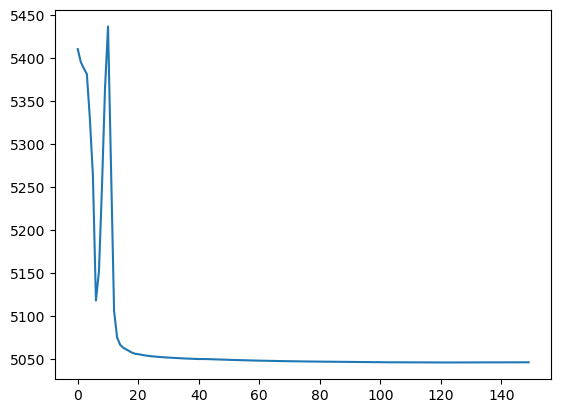

In [9]:
x = [i for i in range(len(accuracy_list))]
y = loss_list


import matplotlib.pyplot as plt
plt.plot(x,y)

## Training Accuracy across epochs

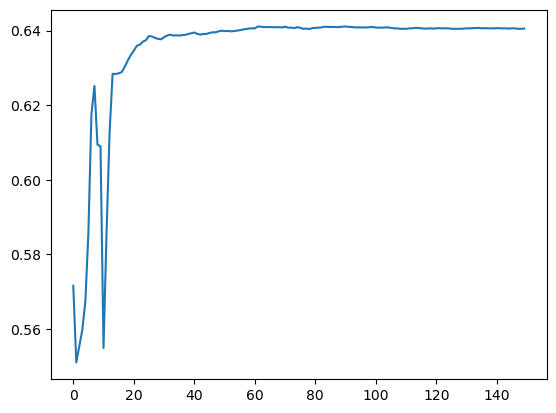

In [10]:
x = [i for i in range(len(accuracy_list))]
y = accuracy_list


import matplotlib.pyplot as plt
plt.plot(x,y)

## Save the list of weights , losses and accuracy metrics

In [11]:
# w_list.append(W)
# u_list.append(U)
# v_list.append(V)
# b_hidden_list.append(b_hidden)
# b_out_list.append(b_out)

In [12]:
np.savez('w_list.npz',*w_list)
np.savez('u_list.npz',*u_list)
np.savez('v_list.npz',*v_list)
np.savez('b_hidden.npz',*b_hidden_list)
np.savez('b_out.npz',*b_out_list)



In [13]:
import pickle
with open('accuracy_list.pickle', 'wb') as f:
    pickle.dump(accuracy_list, f)
    
with open('loss_list.pickle', 'wb') as f:
    pickle.dump(loss_list, f)